# Setup

In [213]:
# Common imports
import numpy as np
import os
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, hstack

# To make the notebook's output stable across runs
random_seed = 12062017
np.random.seed(random_seed)

def notebook_setup(device):
    '''
    Sets the PROJECT_ROOT_DIR, DOWNLOAD_ROOT, DATASET_PATH based on device
    Returns a tuple.
    '''
    if device == 'XPS':
        PROJECT_ROOT_DIR = r'C:\Users\Adrian\Projects\Consulting\Machine-Learning-Examples'
        DOWNLOAD_ROOT = r"C:\Users\Adrian\Google Drive\Datasets"
    elif device == 'Workstation':
        PROJECT_ROOT_DIR = r'C:\Users\aperez\Projects\Consulting\Machine-Learning-Examples'
        DOWNLOAD_ROOT = r"C:\Users\aperez\Google Drive\Datasets"        
    return PROJECT_ROOT_DIR, DOWNLOAD_ROOT

# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set()

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    '''
    Saves fig_id in IMAGES_PATH
    Returns nothing.
    '''
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving fiqure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extenstion, dpi=resolution)
    
def plot_auc(y_test, y_scores_lr):
    '''
    Plots the AUC curve for y_test and y_scores_lr.
    Returns nothing.
    '''   
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    plt.figure()
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()    

In [2]:
# Configures notebook to device
PROJECT_ROOT_DIR, DOWNLOAD_ROOT = notebook_setup('XPS')
# Where to save the fiqures
PROJECT_ID = 'blight-example'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, PROJECT_ID, "images")

BLIGHT_PATH = os.path.join(DOWNLOAD_ROOT, "Blight_Violations")
BLIGHT_URL = "https://data.detroitmi.gov/api/views/ti6p-wcg4/rows.csv?accessType=DOWNLOAD" 

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

# Get the data

In [7]:
def fetch_blight_data(blight_url=BLIGHT_URL, blight_path=BLIGHT_PATH):
    if not os.path.isdir(blight_path):
        os.makedirs(blight_path)
    urllib.request.urlretrieve(blight_url, housing_path)

In [7]:
# DOESN"T WORK
#fetch_blight_data()

In [8]:
def load_blight_data(blight_path=BLIGHT_PATH):
    '''
    Loads the raw blight_violations.csv
    Returns a pandas dataframe.
    '''
    csv_path = os.path.join(blight_path, "Blight_Violations.csv")
    return pd.read_csv(csv_path, encoding='ISO-8859-1')

def pre_processing(blight_df):
    ''' 
    Takes blight panda dataframe and makes column names more reabable, sets ticket_id as index, creates compliance (the 
    prediction variable), and creates compliance_details (explains why a tickets was labeled as complantent or non-complantent).
    Returns a panda dataframe.
    '''
    #  Makes column names more reabable
    columns = blight_df.columns.values.tolist()
    lower_columns = [column.lower().replace(' ', '_').replace('-', '') for column in columns]
    blight_df.columns = lower_columns
    # Sets ticket_id as index
    blight_df.set_index('ticket_id', inplace=True)
    # Defines prediction variable compliance and helper variable compliance_detail
    # The values of these variables are NOT correct
    blight_df['compliance'] = 0
    blight_df['compliance_detail'] = np.NaN    
    return blight_df

def clean_up(blight_df):
    # Removes instances where 'ticket_issued_date' is not in (2000, 2017) 
    blight_df = blight_df[blight_df['ticket_issued_date'].str.contains('[0-9]{2}/[0-9]{2}/[20]{2}[0-9]{2}') == True]
    # Converts 'ticket_issued_date' to datetime
    blight_df['ticket_issued_date'] = pd.to_datetime(blight_df['ticket_issued_date'])
    # Converts 'payment_date' to datetime
    blight_df['payment_date'] = pd.to_datetime(blight_df['payment_date'].str.extract('([0-9]{2}/[0-9]{2}/20{1}[0-9]{2})')) 
    # Converts bad values in 'ticket_issued_time' to NaNs
    blight_df.loc[blight_df['ticket_issued_time'] == '00000000000000.000', 'ticket_issued_time'] = np.nan
    # Converts 'ticket_issued_time' to datetime.time
    blight_df['ticket_issued_time'] = pd.to_datetime(blight_df['ticket_issued_time'], format='%H:%M:%S').dt.time
    # Converts 'hearing_time' to datetime.time
    blight_df['hearing_time'] = pd.to_datetime(blight_df['hearing_time'], format='%H:%M:%S').dt.time
    # Converts 'judgment_amount' to float    
    blight_df['judgment_amount'] = blight_df['judgment_amount'].astype(float)
    return blight_df

def null_compliance(blight_df):
    '''
    Compliance = np.NaN
    Tickets that cannot be classified as compliant or non-compliant because they were ruled as not responsible in disposition
    or they are awaiting judgement.
    Returns a pandas dataframe
    '''
    # Dispositions that are ruled as not responsible or are still pending
    null_dispositions = ['Not responsible by Dismissal', 'Not responsible by City Dismissal', 'PENDING JUDGMENT', 
                 'Not responsible by Determination','SET-ASIDE (PENDING JUDGMENT)']
    # Loops over dispositions and sets 'compliance' values to np.NaN
    # Loops over dispositions and sets 'compliance_detail' values to 'Not Responsible/Pending Judgement'
    for dispositions in null_dispositions:
        blight_df.loc[blight_df['disposition'] == dispositions, 'compliance'] = np.NaN
        blight_df.loc[blight_df['disposition'] == dispositions, 'compliance_detail'] = 'Not Responsible/Pending Judgement'
    return blight_df

def compliant(blight_df):
    '''
    Compliance = 1
    Tickets that are classified as compliant because they had no fine, fine was waved, made a payment with hearing pending,
    early payment (hearing not pending), payment on time, or payment within one month after hearing date.
    Returns a pandas dataframe
    '''
    ## Compliant by no fine
    # Fine Waived by Determintation
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Determination', 'compliance'] = 1
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Determination', 'compliance_detail'] = 'Compliant by no fine'
    # Fine Waived by Admission
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'compliance'] = 1
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'compliance_detail'] = 'Compliant by no fine'
    ## Compliant by Payment
    # Payment with PENDING hearing
    blight_df.loc[(
        (blight_df['hearing_date'] == 'PENDING') &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        (blight_df['hearing_date'] == 'PENDING') &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by payment with PENDING hearing'
    # Transforms values in 'hearing_date' and 'payment_date' to panda date types
    dummy_hearing_date = blight_df['hearing_date'].copy()
    blight_df.loc[blight_df['hearing_date'] == 'PENDING', 'hearing_date'] = np.nan
    blight_df.loc[:, 'hearing_date'] = pd.to_datetime(blight_df['hearing_date'].str.extract('([0-9]{2}/[0-9]{2}/20{1}[0-9]{2})'))
    # Early Payment, payment before hearing date
    blight_df.loc[(
        (blight_df['payment_date'] < blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        (blight_df['payment_date'] < blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by early payment'
    # Payment on time, payment on hearing date
    blight_df.loc[(
        (blight_df['payment_date'] == blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        (blight_df['payment_date'] == blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by payment on time'
    # Payment within one month after hearing date
    blight_df.loc[(
        ((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M') <= 1.0) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        ((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M') <= 1.0) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by payment within 1 Month'
    # Sets 'hearing_date' to orginal state
    blight_df.loc[:, 'hearing_date'] = dummy_hearing_date
    return blight_df

def non_compliant(blight_df):
    '''
    Compliance = 0
    Tickets that are classified as non-compliant because they made no payment or a payment after one month (late payment).
    Returns a pandas dataframe
    '''
    # Transforms values in 'hearing_date' to panda date types
    dummy_hearing_date = blight_df['hearing_date'].copy()
    blight_df.loc[blight_df['hearing_date'] == 'PENDING', 'hearing_date'] = np.nan
    blight_df.loc[:, 'hearing_date'] = pd.to_datetime(blight_df['hearing_date'].str.extract('([0-9]{2}/[0-9]{2}/20{1}[0-9]{2})'))
    # Non-compliant by late payment
    blight_df.loc[(
        ((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M') > 1.0) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Non-compliant by late payment more than 1 month'
    # Non-compliant by no payment
    blight_df.loc[blight_df['compliance_detail'].isnull(), 'compliance_detail'] = 'Non-compliant by no payment'
    # Sets 'hearing_date' to orginal state
    blight_df.loc[:, 'hearing_date'] = dummy_hearing_date
    return blight_df

def populate_compliance(blight_df):
    '''
    Populates compliance and compliance_details in blight_df with the correct values. 
    Returns a panda dataframe.
    '''
    blight_df = null_compliance(blight_df)
    blight_df = compliant(blight_df)
    blight_df = non_compliant(blight_df)  
    return blight_df

def remove_leakage(blight_df):
    ''' 
    In blight_df removes variables to prevent data leakage and variables with mostly NaNs,
    Returns a panda dataframe
    '''
    blight_df = blight_df[['agency_name', 'inspector_name', 'violator_name','violation_street_number', 'violation_street_name', 
                       'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code', 'country', 
                       'ticket_issued_date', 'hearing_date', 'violation_code', 'violation_description', 'disposition', 
                       'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 
                       'judgment_amount', 'latitude', 'longitude', 'compliance']]   
    return blight_df 

def process_blight():
    '''
    Loads the raw blight_violations.csv, cleans the data, and computes compliance.
    Returns a pandas dataframe.
    '''
    blight_df = load_blight_data()
    blight_df = pre_processing(blight_df)
    blight_df = clean_up(blight_df)
    blight_df = populate_compliance(blight_df)
    blight_df = remove_leakage(blight_df)
    return blight_df

def save_blight_data(blight_path, blight_df):
    '''
    Saves the processed blight_df
    Returns nothing.
    '''
    csv_path = os.path.join(blight_path, "Blight_Violations_Processed.csv")
    blight_df.to_csv(csv_path)

In [68]:
blight_df = process_blight()
blight_df = remove_leakage(blight_df)
save_blight_data(BLIGHT_PATH, blight_df)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: DtypeWarning: Columns (0,5,7,8,12,13,28,34,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy

# Data Exploration

In [8]:
def load_processed_blight_data(blight_path=BLIGHT_PATH):
    '''
    Loads the processed blight_violations.csv
    Returns a pandas dataframe.
    '''
    csv_path = os.path.join(blight_path, "Blight_Violations_Processed.csv")
    return pd.read_csv(csv_path, encoding='ISO-8859-1')

blight_df = load_processed_blight_data(blight_path=BLIGHT_PATH)
blight_df.set_index('ticket_id', inplace=True)
blight_df['ticket_issued_date'] = pd.to_datetime(blight_df['ticket_issued_date'])

train_set, test_set = train_test_split(blight_df, test_size=0.2, random_state=random_seed)
explore_df = train_set.copy()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [9]:
blight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339270 entries, 33155 to 378060
Data columns (total 25 columns):
agency_name                   339270 non-null object
inspector_name                339270 non-null object
violator_name                 339198 non-null object
violation_street_number       339270 non-null float64
violation_street_name         339270 non-null object
mailing_address_str_number    334306 non-null object
mailing_address_str_name      339262 non-null object
city                          339269 non-null object
state                         338807 non-null object
zip_code                      339266 non-null object
country                       339270 non-null object
ticket_issued_date            339270 non-null datetime64[ns]
hearing_date                  339270 non-null object
violation_code                339270 non-null object
violation_description         339270 non-null object
disposition                   339270 non-null object
fine_amount                 

## Numerical Attributes

In [221]:
train_set[['admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'judgment_amount']].describe()

,admin_fee,state_fee,late_fee,discount_amount,judgment_amount
count,271416.000000,271416.000000,271416.000000,271416.000000,271416.000000
mean,13.019424,6.509712,20.332207,0.137170,260.209791
std,9.533279,4.766640,51.317315,3.312555,578.816877
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,10.000000,5.000000,0.000000,140.000000
75%,20.000000,10.000000,25.000000,0.000000,305.000000
max,20.000000,10.000000,1000.000000,350.000000,13342.030000


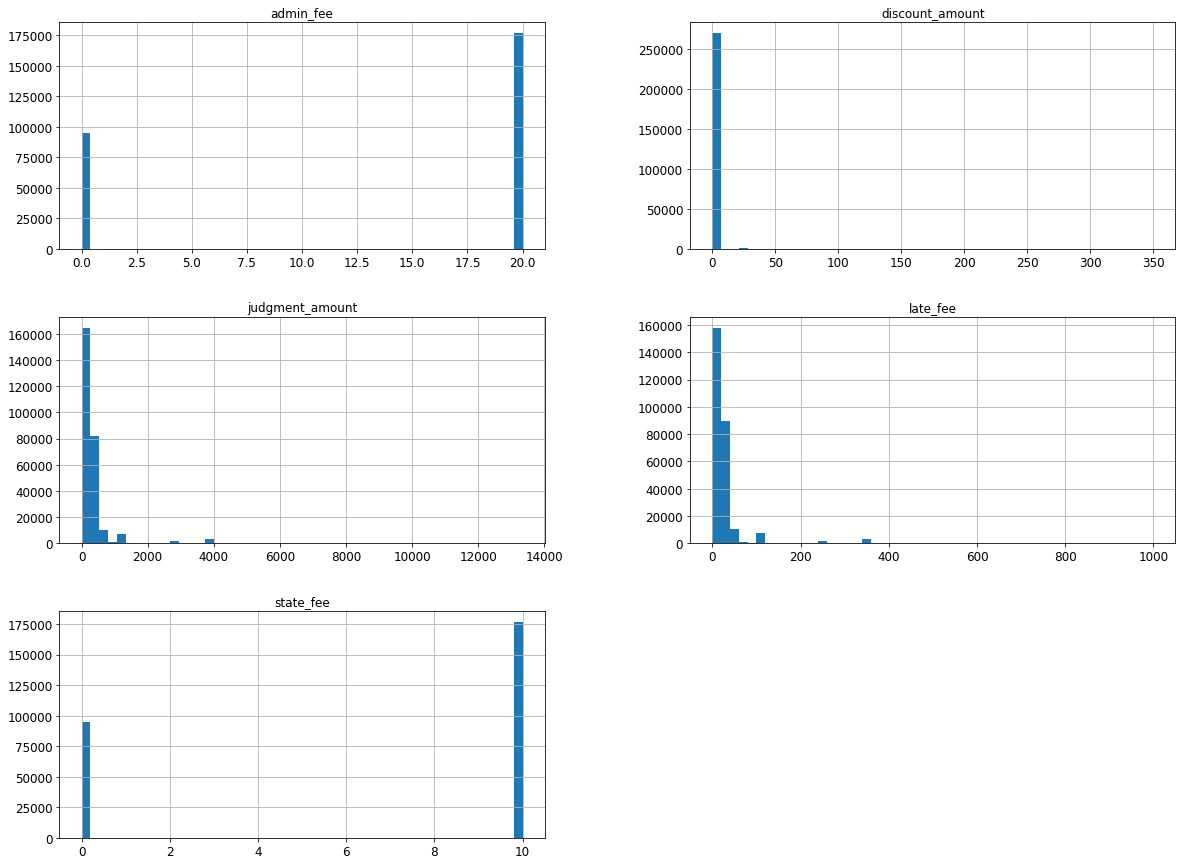

In [222]:
train_set[['admin_fee', 'state_fee', 'late_fee', 'discount_amount','judgment_amount']].hist(bins=50, figsize=(20,15))
plt.show()

In [230]:
explore_df[explore_df['compliance' == 1]].plot.hexbin(x="longitude", y="latitude", C='compliance', figsize=(10,7), sharex=False)

KeyError: False

In [225]:
corr_matrix = explore_df.corr()

In [204]:
corr_matrix["compliance"].sort_values(ascending=False)

compliance                 1.000000
discount_amount            0.119974
violation_street_number   -0.003215
longitude                 -0.012974
latitude                  -0.036038
fine_amount               -0.084672
judgment_amount           -0.091851
late_fee                  -0.162643
admin_fee                       NaN
state_fee                       NaN
Name: compliance, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F1AD80E5F8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001F1AC0FC860>]], dtype=object)

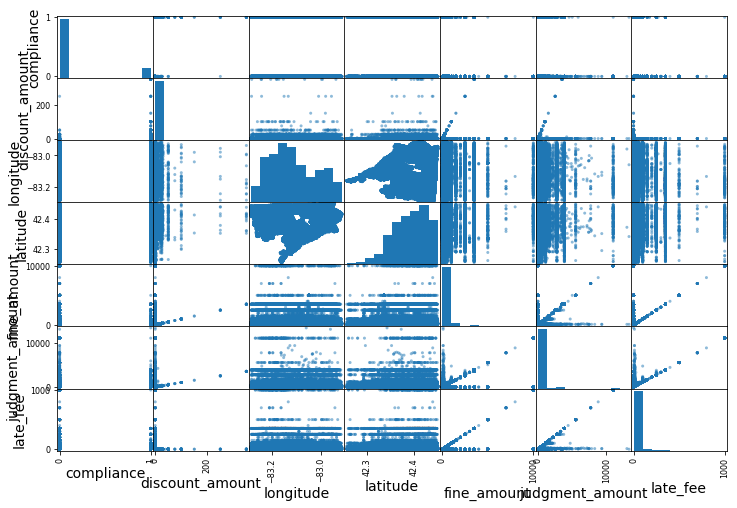

In [125]:
from pandas.plotting import scatter_matrix

attributes = ['compliance', 'discount_amount', 'longitude', 'latitude', 'fine_amount', 'judgment_amount', 'late_fee']
scatter_matrix(blight_df[attributes], figsize=(12,8))

## Catergocial Attributes

In [374]:
explore_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271416 entries, 66781 to 100606
Data columns (total 27 columns):
agency_name                   271416 non-null object
inspector_name                271416 non-null object
violator_name                 271361 non-null object
violation_street_number       271416 non-null float64
violation_street_name         271416 non-null object
mailing_address_str_number    267474 non-null object
mailing_address_str_name      271409 non-null object
city                          271416 non-null object
state                         271051 non-null object
zip_code                      218945 non-null object
country                       271416 non-null object
ticket_issued_date            271416 non-null datetime64[ns]
hearing_date                  271416 non-null object
violation_code                271416 non-null object
violation_description         271416 non-null object
disposition                   271416 non-null object
fine_amount                 

In [57]:
groups = explore_df.groupby('agency_name')
agency_df = pd.DataFrame(groups['compliance'].size())
agency_df ['compliant'] = groups['compliance'].sum().values
agency_df['non_compliant'] = agency_df['compliance'] - agency_df['compliant']
agency_df['%_compliant'] = agency_df['compliant']/agency_df['compliance']
agency_df['%_non_compliant'] = agency_df['non_compliant']/agency_df['compliance']
agency_df

,compliance,compliant,non_compliant,%_compliant,%_non_compliant
agency_name,,,,,
"Buildings, Safety Engineering & Env Department",90117,10232.0,79885.0,0.113541,0.886459
Department of Public Works,74567,13336.0,61231.0,0.178846,0.821154
Detroit Police Department,6315,1246.0,5069.0,0.197308,0.802692
Health Department,5684,823.0,4861.0,0.144792,0.855208
Neighborhood City Halls,1,0.0,1.0,0.000000,1.000000


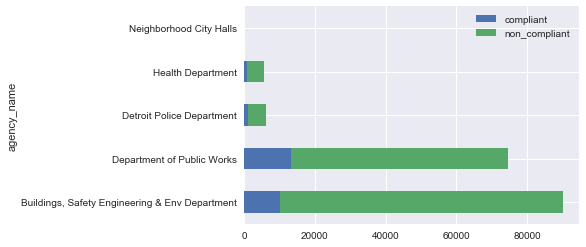

In [60]:
agency_df[['compliant', 'non_compliant']].plot.barh(stacked=True)

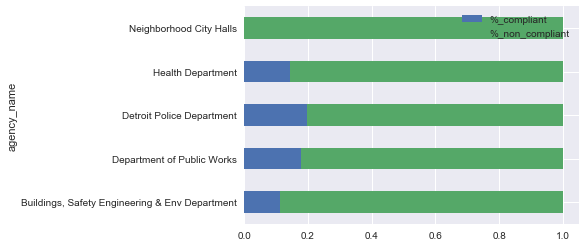

In [59]:
agency_df[['%_compliant', '%_non_compliant']].plot.barh(stacked=True)

In [228]:
groups = explore_df.groupby('inspector_name')
groups['compliance'].agg(np.mean)

inspector_name
Addison, Michael          0.125830
Ahmad, Muna I             0.123874
Anderson, Trevis          0.000000
Anding, Dwight            0.142857
Anding, Tania             1.000000
Askew, Marcus             0.225579
BENNETT, MARGARET         1.000000
BOWLES, TIFFANI           0.125000
Baker, Kenneth            0.172619
Balogun, Samuel                NaN
Barber, Robert            0.062500
Barela, Ralph             0.154739
Baumgardner, Robert P     0.102667
Baxendale, Daniel         0.333333
Bell, Maydell             0.152184
Benavides, Miguel              NaN
Bennett, Margaret         0.162162
Berendt, Raymond          0.000000
Berry, Roberto            0.000000
Bickers-Holmes, Amanda    0.144269
Black, Norma              0.184510
Blue, Abraham             0.113208
Bomar, Isaiah             0.211667
Borden, Kenyetta          0.159574
Bou, Jeffrey              0.275510
Brackett, Ross            0.086517
Brinkley, Kevin           0.085714
Brooks, Eric              0.105172
Brown

In [229]:
explore_df['violation_code'].value_counts()

9-1-36(a)                   91699
9-1-81(a)                   37483
9-1-104                     34234
22-2-88                     23025
22-2-88(b)                  22099
22-2-45                      7033
9-1-110(a)                   6030
9-1-43(a) - (Dwelling)       5094
9-1-105                      4270
9-1-103(C)                   3730
22-2-43                      3645
22-2-22                      3091
9-1-111                      3025
9-1-82(d) - (Dwelling)       2857
22-2-61                      2636
19450901                     2350
9-1-113                      1913
22-2-17                      1595
22-2-88(a)                   1543
9-1-43(a) - (Structures)     1262
61-5-21                      1156
22-2-83(a)(b)(c)              750
61-81.0100/32.0066            681
22-2-83                       571
9-1-50(a)                     536
22-2-83(c)                    492
9-1-43(a) - (Stories)         442
61-5-18                       399
9-1-101                       393
9-1-83 - (Dwel

In [142]:
groups = blight_df.groupby('violation_code')
groups['compliance'].agg(np.mean).sort_values(ascending=False)

violation_code
61-14-175               1.000000
61-5-20                 1.000000
9-1-444                 1.000000
22-2-92                 1.000000
9-1-106                 1.000000
22-2-48(b)              1.000000
61-82.0100/32.0031      1.000000
61-81.0100/45.0807      1.000000
61-81.0100/32.0076B     1.000000
22-2-88(c)              1.000000
61-119.0100/32.0066     1.000000
61-130.0000/130.0400    1.000000
9-1-308                 1.000000
61-47.0000/47.0108      1.000000
22-2-49(b)              0.666667
22-2-20                 0.666667
22-2-49(a)              0.618421
9-1-216                 0.571429
22-2-49(d)              0.515152
22-2-83(a)(c)           0.500000
9-1-333                 0.500000
61-90.0100              0.500000
19840901                0.500000
20180901                0.461538
9-1-111(b)              0.428571
61-85.0100/32.0066      0.428571
22-2-55                 0.428571
61-63.0100              0.408451
9-1-301                 0.400000
22-2-23                 0.35

In [55]:
groups = explore_df.groupby('disposition')
disposition_df = pd.DataFrame(groups['compliance'].size())
disposition_df ['compliant'] = groups['compliance'].sum().values
disposition_df['non_compliant'] = disposition_df['compliance'] - disposition_df['compliant']
disposition_df['%_compliant'] = disposition_df['compliant']/disposition_df['compliance']
disposition_df['%_non_compliant'] = disposition_df['non_compliant']/disposition_df['compliance']
disposition_df

,compliance,compliant,non_compliant,%_compliant,%_non_compliant
disposition,,,,,
Responsible (Fine Waived) by Admission,1,1.0,0.0,1.000000,0.000000
Responsible (Fine Waived) by Determination,792,792.0,0.0,1.000000,0.000000
Responsible - Compl/Adj by Default,5,0.0,5.0,0.000000,1.000000
Responsible - Compl/Adj by Determination,2,1.0,1.0,0.500000,0.500000
Responsible by Admission,14527,13280.0,1247.0,0.914160,0.085840
Responsible by Default,151947,7606.0,144341.0,0.050057,0.949943
Responsible by Determination,9409,3957.0,5452.0,0.420555,0.579445
Responsible by Dismissal,1,0.0,1.0,0.000000,1.000000


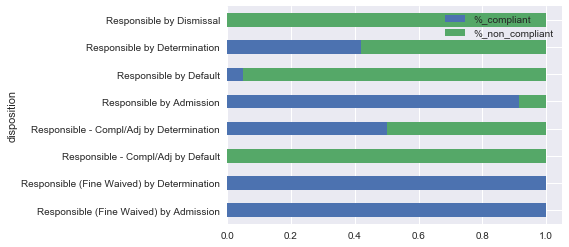

In [56]:
disposition_df[['%_compliant', '%_non_compliant']].plot.barh(stacked=True)

In [231]:
groups = explore_df.groupby('country')
groups['compliance'].agg(np.sum).sort_values(ascending=False)

country
USA                         25634.0
Egypt                           1.0
Canada                          1.0
Australia                       1.0
Germany                         0.0
United States of America        NaN
Name: compliance, dtype: float64

## New Features

In [57]:
def create_resident(explore_df):
    '''
    Computes a measurement on where the defendent lives. 
    0 - Out of state, 1 - In State, 2 - In Det, MI.
    Returns a panda series.
    '''
    # Fix 'zip_code' - Convert dashed zipcodes to undashed
    explore_df.loc[:, 'zip_code'] = blight_df['zip_code'].str.split('-').str[0]
    # Fix 'city' - covert all to lowercase and missing values to unknown
    explore_df.loc[:, 'city'] = explore_df['city'].str.lower()
    explore_df.loc[blight_df['city'].isnull(), 'city'] = 'Unknown'
    # Ticket is issued to an individual who lives in Detriot, MI
    explore_df['local_resident'] = 0
    explore_df.loc[(explore_df['city'].str.contains('(^det)')) & (explore_df['state'] == 'MI'), 'local_resident'] = 1
    # Tickets is issued to an individual who lives in MI
    explore_df['state_resident'] = 0
    explore_df.loc[explore_df['state'] == 'MI', 'state_resident'] = 1
    explore_df['resident'] = explore_df['state_resident'] + explore_df['local_resident']
    return explore_df['resident']  

def create_days_difference(explore_df):
    '''
    Computes the absolute number of days between 'ticket_issued_date' and 'hearing_date.
    Returns a pd series.
    '''
    # If 'hearing_date' is 'PENDING' then sets them to the same date as 'ticket_issued_date'
    explore_df.loc[explore_df['hearing_date'] == 'PENDING', 'hearing_date'] = explore_df.loc[explore_df['hearing_date'] == 'PENDING', 'ticket_issued_date']
    # Computes number of difference in number of days
    explore_df['days_difference'] = pd.DatetimeIndex(explore_df['hearing_date']) - pd.DatetimeIndex(explore_df['ticket_issued_date'])
    # Transforms number of days to int and absolute value
    explore_df['days_difference'] = abs(explore_df['days_difference']/np.timedelta64(1, 'D'))
    explore_df.loc[explore_df['days_difference'] > 202, 'days_difference'] = np.NaN
    return explore_df['days_difference']

def create_violation_code_root(explore_df):
    '''
    Find the root violation code.
    Returns a pandas dataframe.
    '''
    explore_df['violation_code_root'] = explore_df['violation_code'].str.split('(').str[0].str.split('/').str[0].str.split('.').str[0]
    explore_df['violation_code_root'] = explore_df['violation_code_root'].str.split('-').str[0:2].str.join('')
    return explore_df['violation_code_root']

def create_disposition_clean(explore_df):
    '''
    Simplies the levels in 'disposition' from 7 to 4. Some values can result in nulls
    Returns a pd series.
    '''
    explore_df['disposition_clean'] = np.NaN
    explore_df.loc[explore_df['disposition'] == 'Responsible (Fine Waived) by Determination', 'disposition_clean'] = 'Fine Waived'
    explore_df.loc[explore_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'disposition_clean'] = 'Fine Waived'
    explore_df.loc[explore_df['disposition'] == 'Responsible by Default', 'disposition_clean'] = 'Default'
    explore_df.loc[explore_df['disposition'] == 'Responsible by Admission', 'disposition_clean'] = 'Admission'
    explore_df.loc[explore_df['disposition'] == 'Responsible by Determination', 'disposition_clean'] = 'Determination'
    explore_df.loc[explore_df['disposition'] == 'Responsible - Compl/Adj by Default', 'disposition_clean'] = 'Default'
    explore_df.loc[explore_df['disposition'] == 'Responsible - Compl/Adj by Determination', 'disposition_clean'] = 'Determination'
    return explore_df['disposition_clean']

In [58]:
# Drop row where 'compliance' is NaN
explore_df.dropna(subset=['compliance'], inplace=True)

In [60]:
explore_df['disposition_clean'] = create_disposition_clean(explore_df)
explore_df.dropna(subset=['disposition_clean'], inplace=True)

In [61]:
groups = explore_df.groupby('disposition_clean')
disposition_df = pd.DataFrame(groups['compliance'].size())
disposition_df ['compliant'] = groups['compliance'].sum().values
disposition_df['non_compliant'] = disposition_df['compliance'] - disposition_df['compliant']
disposition_df['%_compliant'] = disposition_df['compliant']/disposition_df['compliance']
disposition_df['%_non_compliant'] = disposition_df['non_compliant']/disposition_df['compliance']
disposition_df

,compliance,compliant,non_compliant,%_compliant,%_non_compliant
disposition_clean,,,,,
Admission,14527,13280.0,1247.0,0.914160,0.085840
Default,151952,7606.0,144346.0,0.050055,0.949945
Determination,9411,3958.0,5453.0,0.420572,0.579428
Fine Waived,793,793.0,0.0,1.000000,0.000000


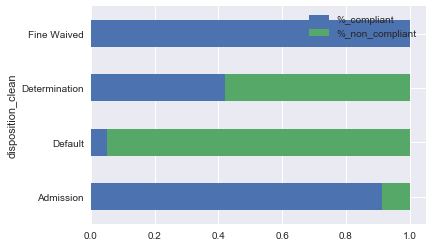

In [62]:
disposition_df[['%_compliant', '%_non_compliant']].plot.barh(stacked=True)

In [36]:
groups = explore_df.groupby('local_resident')
resident_df = pd.DataFrame(groups['compliance'].size())
resident_df ['compliant'] = groups['compliance'].sum().values
resident_df['non_compliant'] = resident_df['compliance'] - resident_df['compliant']
resident_df['%_compliant'] = resident_df['compliant']/resident_df['compliance']
resident_df['%_non_compliant'] = resident_df['non_compliant']/resident_df['compliance']
resident_df

,compliance,compliant,non_compliant,%_compliant,%_non_compliant
local_resident,,,,,
0,109801,11150.0,98651.0,0.101547,0.898453
1,161615,14487.0,147128.0,0.089639,0.910361


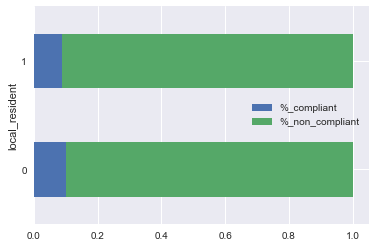

In [37]:
resident_df[['%_compliant', '%_non_compliant']].plot.barh(stacked=True)

In [38]:
groups = explore_df.groupby('state_resident')
resident_df = pd.DataFrame(groups['compliance'].size())
resident_df ['compliant'] = groups['compliance'].sum().values
resident_df['non_compliant'] = resident_df['compliance'] - resident_df['compliant']
resident_df['%_compliant'] = resident_df['compliant']/resident_df['compliance']
resident_df['%_non_compliant'] = resident_df['non_compliant']/resident_df['compliance']
resident_df

,compliance,compliant,non_compliant,%_compliant,%_non_compliant
state_resident,,,,,
0,26883,2616.0,24267.0,0.097311,0.902689
1,244533,23021.0,221512.0,0.094143,0.905857


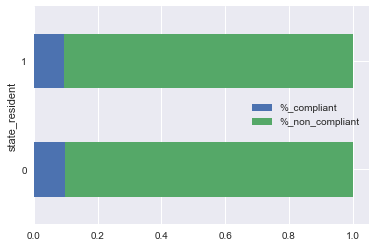

In [39]:
resident_df[['%_compliant', '%_non_compliant']].plot.barh(stacked=True)

In [40]:
explore_df['resident'] = explore_df['state_resident'] + explore_df['local_resident']

In [41]:
groups = explore_df.groupby('resident')
resident_df = pd.DataFrame(groups['compliance'].size())
resident_df ['compliant'] = groups['compliance'].sum().values
resident_df['non_compliant'] = resident_df['compliance'] - resident_df['compliant']
resident_df['%_compliant'] = resident_df['compliant']/resident_df['compliance']
resident_df['%_non_compliant'] = resident_df['non_compliant']/resident_df['compliance']
resident_df

,compliance,compliant,non_compliant,%_compliant,%_non_compliant
resident,,,,,
0,26883,2616.0,24267.0,0.097311,0.902689
1,82918,8534.0,74384.0,0.102921,0.897079
2,161615,14487.0,147128.0,0.089639,0.910361


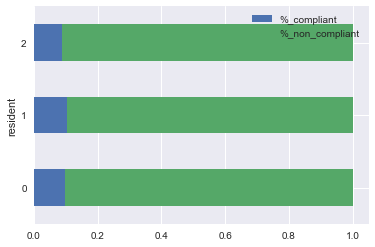

In [42]:
resident_df[['%_compliant', '%_non_compliant']].plot.barh(stacked=True)

In [38]:
# Year ticket is issued
explore_df['ticket_issued_year'] = pd.DatetimeIndex(explore_df['ticket_issued_date']).year
# Month ticket is issued
explore_df['ticket_issued_month'] = pd.DatetimeIndex(explore_df['ticket_issued_date']).month

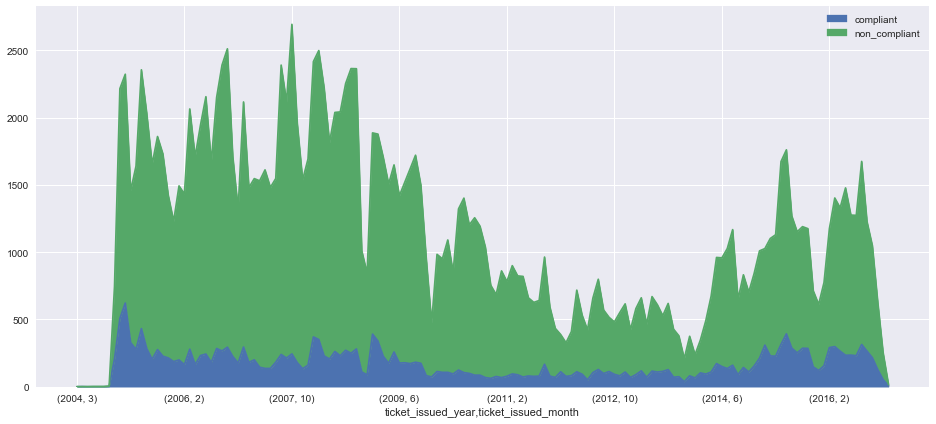

In [39]:
groups = explore_df.groupby(['ticket_issued_year', 'ticket_issued_month'])
monthly_df = pd.DataFrame(groups['compliance'].size())
monthly_df['compliant'] = groups['compliance'].sum().values
monthly_df['non_compliant'] = monthly_df['compliance'] - monthly_df['compliant']
monthly_df[['compliant', 'non_compliant']].plot.area(figsize=(16,7))

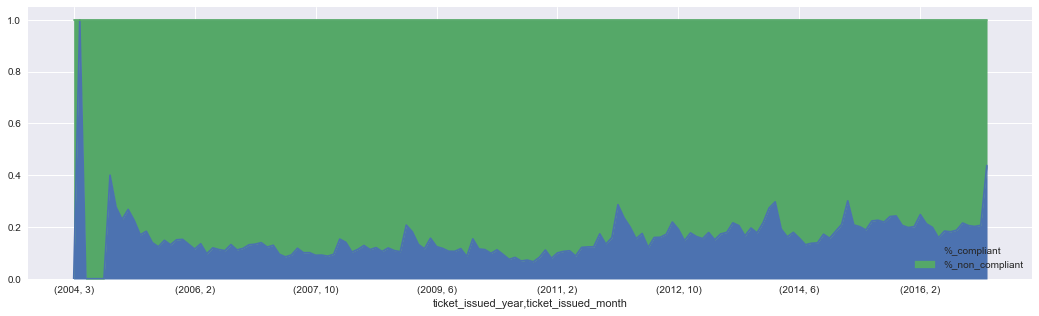

In [40]:
monthly_df['%_compliant'] = monthly_df['compliant']/monthly_df['compliance']
monthly_df['%_non_compliant'] = monthly_df['non_compliant']/monthly_df['compliance']
monthly_df[['%_compliant', '%_non_compliant']].plot.area(figsize=(18,5))

In [30]:
explore_df['violation_code_root'] = create_violation_code_root(explore_df)

In [31]:
explore_df['violation_code_root'].value_counts()

91          125261
222          48468
19450901      1286
615            759
6181           364
614            113
6163           105
20130901        90
618             88
19420901        33
223             17
20180901        13
6180            11
61101            9
19830901         9
6185             7
6182             5
6183             5
19410901         5
61130            4
6186             4
6184             4
61112            3
61104            2
6114             2
61121            2
19840901         2
6190             2
61103            2
6147             1
19910901         1
61114            1
61119            1
19850901         1
61102            1
61111            1
20160901         1
6145             1
Name: violation_code_root, dtype: int64

In [32]:
groups = explore_df.groupby('violation_code_root')
violation_df = pd.DataFrame(groups['compliance'].size())
violation_df ['compliant'] = groups['compliance'].sum().values
violation_df['non_compliant'] = violation_df['compliance'] - violation_df['compliant']
violation_df['%_compliant'] = violation_df['compliant']/violation_df['compliance']
violation_df['%_non_compliant'] = violation_df['non_compliant']/violation_df['compliance']
violation_df

,compliance,compliant,non_compliant,%_compliant,%_non_compliant
violation_code_root,,,,,
19410901,5,1.0,4.0,0.200000,0.800000
19420901,33,7.0,26.0,0.212121,0.787879
19450901,1286,54.0,1232.0,0.041991,0.958009
19830901,9,1.0,8.0,0.111111,0.888889
19840901,2,1.0,1.0,0.500000,0.500000
19850901,1,0.0,1.0,0.000000,1.000000
19910901,1,0.0,1.0,0.000000,1.000000
20130901,90,11.0,79.0,0.122222,0.877778
20160901,1,0.0,1.0,0.000000,1.000000


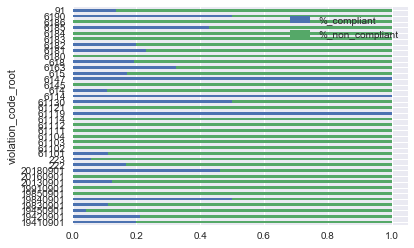

In [34]:
violation_df[['%_compliant', '%_non_compliant']].plot.barh(stacked=True)

In [18]:
explore_df['days_difference'] = create_days_difference(explore_df)

In [19]:
explore_df.loc[:, 'days_difference'].describe()

count    263086.000000
mean         56.456828
std          43.698875
min           0.000000
25%          25.000000
50%          42.000000
75%          78.000000
max         202.000000
Name: days_difference, dtype: float64

# Prepare Data for Machine Learning

In [136]:
violations_df = train_set[['agency_name', 'city', 'state', 'ticket_issued_date', 'hearing_date', 'violation_code', 
            'disposition', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'judgment_amount', 
            'latitude', 'longitude', 'compliance']].copy()
violations_df.loc[violations_df['disposition'] == 'Responsible by Dismissal', 'compliance'] = np.NaN
violations_df.dropna(subset=['compliance'], inplace=True)
violation_labels = violations_df['compliance'].copy()

In [137]:
violations_df['days_difference'] = create_days_difference(violations_df)
violations_df['resident'] = create_resident(violations_df)
#violations_df['violation_code_root'] = create_violation_code_root(violations_df)
violations_df.drop(['state_resident', 'local_resident', 'city', 'state', 'ticket_issued_date', 'hearing_date', 'violation_code',
                   'zip_code'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [138]:
violations_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176683 entries, 66781 to 100606
Data columns (total 13 columns):
agency_name        176683 non-null object
disposition        176683 non-null object
fine_amount        176683 non-null float64
admin_fee          176683 non-null float64
state_fee          176683 non-null float64
late_fee           176683 non-null float64
discount_amount    176683 non-null float64
judgment_amount    176683 non-null float64
latitude           168190 non-null float64
longitude          168190 non-null float64
compliance         176683 non-null float64
days_difference    172588 non-null float64
resident           176683 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 18.9+ MB


In [139]:
sample_incomplete_rows = violations_df[violations_df.isnull().any(axis=1)]
sample_incomplete_rows.head()

,agency_name,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,latitude,longitude,compliance,days_difference,resident
ticket_id,,,,,,,,,,,,,
66781,"Buildings, Safety Engineering & Env Department",Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,NaN,NaN,0.0,46.0,2
377001,"Buildings, Safety Engineering & Env Department",Responsible by Admission,250.0,20.0,10.0,0.0,0.0,280.0,NaN,NaN,1.0,14.0,0
116378,Department of Public Works,Responsible by Default,200.0,20.0,10.0,20.0,0.0,250.0,NaN,NaN,0.0,24.0,2
36296,"Buildings, Safety Engineering & Env Department",Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,NaN,NaN,0.0,192.0,1
243404,"Buildings, Safety Engineering & Env Department",Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,NaN,NaN,0.0,36.0,2


In [140]:
violation_num = violations_df.select_dtypes(include=[np.number]).copy()
violation_num.drop('compliance', axis=1, inplace=True)
violation_num.head()

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,latitude,longitude,days_difference,resident
ticket_id,,,,,,,,,,
66781,250.0,20.0,10.0,25.0,0.0,305.0,NaN,NaN,46.0,2
377001,250.0,20.0,10.0,0.0,0.0,280.0,NaN,NaN,14.0,0
207205,250.0,20.0,10.0,25.0,0.0,305.0,42.368227,-83.172557,95.0,2
116378,200.0,20.0,10.0,20.0,0.0,250.0,NaN,NaN,24.0,2
109139,50.0,20.0,10.0,5.0,0.0,85.0,42.411080,-83.179877,90.0,1


In [141]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
imputer.fit(violation_num)
imputer.statistics_

array([ 250.        ,   20.        ,   10.        ,   25.        ,
          0.        ,  305.        ,   42.39601182,  -83.12823949,
         43.        ,    2.        ])

In [142]:
X = imputer.transform(violation_num)
violation_tr = pd.DataFrame(X, columns=violation_num.columns,
                          index = list(violations_df.index.values))
violation_tr.loc[sample_incomplete_rows.index.values].head()

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,latitude,longitude,days_difference,resident
66781,250.0,20.0,10.0,25.0,0.0,305.0,42.396012,-83.128239,46.0,2.0
377001,250.0,20.0,10.0,0.0,0.0,280.0,42.396012,-83.128239,14.0,0.0
116378,200.0,20.0,10.0,20.0,0.0,250.0,42.396012,-83.128239,24.0,2.0
36296,250.0,20.0,10.0,25.0,0.0,305.0,42.396012,-83.128239,192.0,1.0
243404,250.0,20.0,10.0,25.0,0.0,305.0,42.396012,-83.128239,36.0,2.0


In [143]:
violation_tr = pd.DataFrame(X, columns=violation_num.columns)
violation_tr.head()

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,latitude,longitude,days_difference,resident
0,250.0,20.0,10.0,25.0,0.0,305.0,42.396012,-83.128239,46.0,2.0
1,250.0,20.0,10.0,0.0,0.0,280.0,42.396012,-83.128239,14.0,0.0
2,250.0,20.0,10.0,25.0,0.0,305.0,42.368227,-83.172557,95.0,2.0
3,200.0,20.0,10.0,20.0,0.0,250.0,42.396012,-83.128239,24.0,2.0
4,50.0,20.0,10.0,5.0,0.0,85.0,42.411080,-83.179877,90.0,1.0


In [144]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

violation_num_tr = num_pipeline.fit_transform(violation_num)

In [146]:
violations_df['disposition_clean'] = create_disposition_clean(violations_df)
violations_df.dropna(subset=['disposition_clean'], inplace=True)
violations_df.drop('disposition', axis=1, inplace=True)

In [147]:
violations_agency = violations_df['agency_name']
cat_encoder_ag = CategoricalEncoder()
violations_agency_reshaped = violations_agency.values.reshape(-1, 1)
violations_agency_1hot = cat_encoder_ag.fit_transform(violations_agency_reshaped)

In [148]:
violations_disp = violations_df['disposition_clean']
cat_encoder_disp = CategoricalEncoder()
violations_disp_reshaped = violations_disp.values.reshape(-1, 1)
violations_disp_1hot = cat_encoder_disp.fit_transform(violations_disp_reshaped)

In [149]:
violations_columns = list(violation_num.columns)+list(cat_encoder_ag.categories_[0]) + list(cat_encoder_disp.categories_[0])

In [150]:
violation_num_tr.shape

(176683, 10)

In [151]:
violations_agency_1hot.shape

(176683, 5)

In [152]:
violations_disp_1hot.shape

(176683, 4)

In [165]:
from scipy.sparse import coo_matrix, hstack
X = hstack([violation_num_tr, violations_agency_1hot, violations_disp_1hot])

## Feature Selection

In [169]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

forest = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1, max_features='auto', max_depth=5)
forest.fit(X, np.ravel(violation_labels))

# Print the feature ranking
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print('Features with Importance Greather than 0.05')
for f in range(X.shape[1]):
    if importances[indices[f]] >= 0.0000000001:
        print("%d. %s (%f)" % (f + 1, violations_columns[indices[f]], importances[indices[f]]))

Features with Importance Greather than 0.05
1. Default (0.429924)
2. Admission (0.392895)
3. Determination (0.073773)
4. Fine Waived (0.030942)
5. late_fee (0.027112)
6. Buildings, Safety Engineering & Env Department (0.009624)
7. discount_amount (0.008725)
8. days_difference (0.008051)
9. judgment_amount (0.006132)
10. fine_amount (0.005337)
11. Department of Public Works (0.004739)
12. Health Department (0.001070)
13. latitude (0.000677)
14. Detroit Police Department (0.000489)
15. resident (0.000406)
16. longitude (0.000101)
17. Neighborhood City Halls (0.000000)


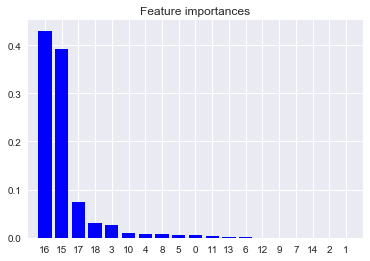

In [170]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [225]:
# Tranform data based on Random Forest
model = SelectFromModel(forest, prefit=True, threshold = 0.001)
X_transform = model.transform(X)

In [226]:
nnclf = MLPClassifier(hidden_layer_sizes = [18], activation='relu', solver='adam', random_state = 0, alpha = 5)
nnclf.fit(X_transform, np.ravel(violation_labels))

MLPClassifier(activation='relu', alpha=5, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[18], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### Test Date

In [220]:
nn_test_df = test_set[['agency_name', 'city', 'state', 'ticket_issued_date', 'hearing_date', 'violation_code', 
            'disposition', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'judgment_amount', 
            'latitude', 'longitude', 'compliance']].copy()
nn_test_df.loc[nn_test_df['disposition'] == 'Responsible by Dismissal', 'compliance'] = np.NaN
nn_test_df.dropna(subset=['compliance'], inplace=True)
nn_test_labels = nn_test_df['compliance'].copy()
nn_test_df.head()

,agency_name,city,state,ticket_issued_date,hearing_date,violation_code,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,latitude,longitude,compliance
ticket_id,,,,,,,,,,,,,,,,
29945,"Buildings, Safety Engineering & Env Department",Dearborn,MI,2005-04-08,06/02/2005,9-1-81(a),Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,42.337045,-83.228728,0.0
369591,"Buildings, Safety Engineering & Env Department",DETROIT,MI,2016-09-09,09/26/2016,9-1-36(a),Responsible by Admission,250.0,20.0,10.0,0.0,0.0,280.0,42.373288,-83.176531,1.0
261254,"Buildings, Safety Engineering & Env Department",Detroit,MI,2010-09-16,11/01/2010,9-1-81(a),Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,42.313461,-83.112773,0.0
94101,Department of Public Works,OAK PARK,MI,2006-09-28,10/18/2006,22-2-88,Responsible by Determination,1000.0,20.0,10.0,100.0,0.0,1130.0,42.442581,-83.268736,1.0
148851,"Buildings, Safety Engineering & Env Department",LIVONIA,MI,2007-11-26,04/04/2008,9-1-81(a),Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,42.391308,-83.259883,0.0


In [221]:
nn_test_df['days_difference'] = create_days_difference(nn_test_df)
nn_test_df['resident'] = create_resident(nn_test_df)
nn_test_df.drop(['state_resident', 'local_resident', 'city', 'state', 'ticket_issued_date', 'hearing_date', 'violation_code',
                   'zip_code', 'compliance'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [222]:
nn_test_num = nn_test_df.select_dtypes(include=[np.number]).copy()
nn_test_num_tr = num_pipeline.fit_transform(nn_test_num)

In [223]:
nn_test_df['disposition_clean'] = create_disposition_clean(nn_test_df )
nn_test_df.dropna(subset=['disposition_clean'], inplace=True)
nn_test_df.drop('disposition', axis=1, inplace=True)

nn_test_agency = nn_test_df['agency_name']
nn_test_agency_reshaped = nn_test_agency.values.reshape(-1, 1)
nn_test_agency_1hot = cat_encoder_ag.transform(nn_test_agency_reshaped)

nn_test_disp = nn_test_df['disposition_clean']
nn_test_disp_reshaped = nn_test_disp.values.reshape(-1, 1)
nn_test_disp_1hot = cat_encoder_disp.transform(nn_test_disp_reshaped)

X_test = hstack([nn_test_num_tr, nn_test_agency_1hot, nn_test_disp_1hot])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


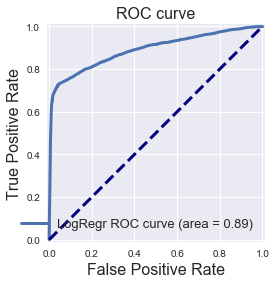

In [227]:
X_test_transform = model.transform(X_test)
y_probs = nnclf.predict_proba(X_test_transform)
plot_auc(nn_test_labels, y_probs[:,1])